## Medical Vision-Language Model

### Background

A medical VLM is a multimodal model taking medical images and texts as the input. Please read the next papers if you are not famliar with this task:

[1] Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., ... & Sutskever, I. (2021, July). Learning transferable visual models from natural language supervision. In International conference on machine learning (pp. 8748-8763). PMLR. https://arxiv.org/pdf/2103.00020.pdf


[2] Wang, Z., Wu, Z., Agarwal, D., & Sun, J. (2022). Medclip: Contrastive learning from unpaired medical images and text. EMNLP'22. https://arxiv.org/pdf/2210.10163.pdf


We will now use the code provided in [2] to complete some ML tasks related to medical vision and language.

In [89]:
'''
conda create --name medclip
conda activate medclip
pip install -r requirement.txt
pip install ipykernel
python -m ipykernel install --user --name medclip --display name meclip
pip install git+https://github.com/RyanWangZf/MedCLIP.git
'''

'\nconda create --name medclip\nconda activate medclip\npip install -r requirement.txt\npip install ipykernel\npython -m ipykernel install --user --name medclip --display name meclip\npip install git+https://github.com/RyanWangZf/MedCLIP.git\n'

### Preparation

Please refer to the github repo of [2] in https://github.com/RyanWangZf/MedCLIP to install the package and download the pretrained model weights in your environment.

After they are done, you should be able to run the following code.

In [107]:
from medclip import MedCLIPModel, MedCLIPVisionModelViT, MedCLIPVisionModel

# load MedCLIP-ViT
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.cuda()
print()

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.t

load model weight from: ./pretrained/medclip-vit



Also, you will need to download the raw image data from

https://github.com/RyanWangZf/codetest-medvlm-data

and put them in the folder `./data`.

### Task 1: image encoding and retrieval

You already have the x-rays (obtained from [CheXpert-small](https://www.kaggle.com/datasets/willarevalo/chexpert-v10-small)) in the folder `./data`. Now let's utlize MedCLIP to encode all images into dense embeddings.

In [91]:
import os
from PIL import Image

def read_images(dir_path = ""):
    if not os.path.exists(dir_path):
        raise ValueError("Directory not exist.")
    
    pil_images = []

    for file in os.listdir(dir_path):
        img = Image.open(os.path.join(dir_path, file))
        pil_images.append(img)

    return pil_images

In [92]:
from medclip import MedCLIPProcessor

processor = MedCLIPProcessor()
dir_path = "./data"
pil_images = read_images(dir_path)
print(f"Dir:  {dir_path} Image Number: {len(pil_images)}")

inputs = processor(
    text=[""], 
    images=pil_images, 
    return_tensors="pt", 
    padding=True
    )

outputs = model(**inputs)
outputs.keys()

Dir:  ./data Image Number: 20


dict_keys(['img_embeds', 'text_embeds', 'logits', 'loss_value', 'logits_per_text'])

In [93]:
outputs['img_embeds'].shape

torch.Size([20, 512])

Can you select one of the images, and then find the most similar image from others by comparing their cosine similarities?

In [94]:
import matplotlib.pyplot as plt
def show_image(dir, img_id):
    img_name = os.listdir(dir)[img_id]
    img = Image.open(os.path.join(dir, img_name))
    plt.imshow(img)
    plt.show()

def cosine_sim(embed, embeds):
    '''
        Compute the cosine similarity between one embedding and a list of embeddings
    '''
    norm_embed = embed / (embed**2).sum().sqrt()
    norm_embeds = embeds.T / (embeds**2).sum(axis=1).sqrt()
    norm_embeds = norm_embeds.T
    
    return norm_embeds @ norm_embed

The similarity of 0 with other images are: tensor([1.0000, 0.9660, 0.9372, 0.9471, 0.9784, 0.9608, 0.9732, 0.9603, 0.9566,
        0.9783, 0.9822, 0.9662, 0.9530, 0.9536, 0.9378, 0.9480, 0.9540, 0.9839,
        0.9428, 0.9755], device='cuda:0', grad_fn=<MvBackward0>)
The most similar image is 17


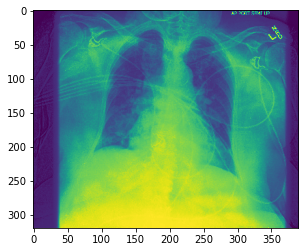

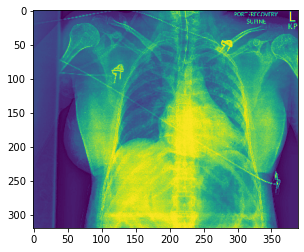

In [95]:
# Select image 0
index = 0
sims = cosine_sim(outputs['img_embeds'][index], outputs['img_embeds'])
max_id = sims.argmax()
if max_id == index: # Skip the original image
    max_id = sims.argsort()[-2]
print("The similarity of {} with other images are: {}".format(index, sims))
print("The most similar image is {}".format(max_id))
show_image(dir_path, index)
show_image(dir_path, max_id)


### Task 2: prompt-based classification

The pretrained MedCLIP model is able to do classification using prompts. Please select one of the image and use `PromptClassifier` provided by `medclip` to make image classification by prompts.

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.t

load model weight from: ./pretrained/medclip-vit
Image: 216736.png


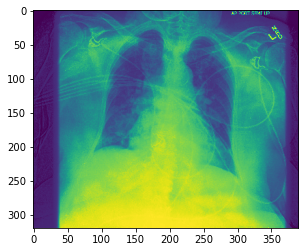

sample 10 num of prompts for Atelectasis from total 210
sample 10 num of prompts for Cardiomegaly from total 15
sample 10 num of prompts for Consolidation from total 192
sample 10 num of prompts for Edema from total 18
sample 10 num of prompts for Pleural Effusion from total 54

Image Index: 0 Image Name: 216736.png Class: Edema


In [96]:
from medclip import PromptClassifier
from medclip.prompts import generate_chexpert_class_prompts, process_class_prompts
from medclip import MedCLIPModel, MedCLIPVisionModelViT, MedCLIPVisionModel

# load MedCLIP-ViT
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.cuda()

def classify(img, processor, clf, cls_prompts):
    inputs = processor(images=img, return_tensors="pt")
    inputs['prompt_inputs'] = cls_prompts
    output = clf(**inputs)
    max_id = output['logits'].argmax()
    return max_id, output['class_names'][max_id]
    

processor = MedCLIPProcessor()
clf = PromptClassifier(model, ensemble=True)
clf.cuda()

# Select Image 0
index = 0

filename = os.listdir(dir_path)[index]
print("Image: {}".format(filename))
img = Image.open(os.path.join(dir_path, filename))
show_image(dir_path, index)

cls_prompts = process_class_prompts(generate_chexpert_class_prompts(n=10))
print()
max_id, class_name = classify(img, processor, clf, cls_prompts)
print("Image Index: {} Image Name: {} Class: {}".format(index, filename, class_name))

Apart from the prompts provided by `generate_chexpert_class_prompts` in medclip, can you manually create some more prompts and compare the prediction results with the provided prompts?

In [97]:
print("Prompt {} Classification Result:".format("generate_chexpert_class_prompts"))
result0 = []
for i in range(20):
    filename = os.listdir(dir_path)[i]
    img = Image.open(os.path.join(dir_path, filename))
    max_id, class_name = classify(img, processor, clf, cls_prompts)
    print("Image Index: {}\tImage Name: {}\tClass: {}".format(i, filename, class_name))
    result0.append(class_name)

Prompt generate_chexpert_class_prompts Classification Result:
Image Index: 0	Image Name: 216736.png	Class: Edema
Image Index: 1	Image Name: 100538.png	Class: Atelectasis
Image Index: 2	Image Name: 98619.png	Class: Consolidation
Image Index: 3	Image Name: 9197.png	Class: Pleural Effusion
Image Index: 4	Image Name: 86140.png	Class: Cardiomegaly
Image Index: 5	Image Name: 139131.png	Class: Atelectasis
Image Index: 6	Image Name: 102455.png	Class: Atelectasis
Image Index: 7	Image Name: 173746.png	Class: Pleural Effusion
Image Index: 8	Image Name: 73807.png	Class: Pleural Effusion
Image Index: 9	Image Name: 222434.png	Class: Edema
Image Index: 10	Image Name: 119654.png	Class: Cardiomegaly
Image Index: 11	Image Name: 127767.png	Class: Pleural Effusion
Image Index: 12	Image Name: 117424.png	Class: Pleural Effusion
Image Index: 13	Image Name: 106338.png	Class: Cardiomegaly
Image Index: 14	Image Name: 51979.png	Class: Pleural Effusion
Image Index: 15	Image Name: 212881.png	Class: Pleural Effusio

In [98]:
prompts = {"Edema":"Edema", 
           "Consolidation":"Consolidation",
           "Atelectasis":"Atelectasis", 
           "Pleural Effusion":"Pleural Effusion",
           "Cardiomegaly":"Cardiomegaly",
           }

result1 = []
new_prompts = process_class_prompts(prompts)

print("New Prompt1: Only use the class name")
for i in range(20):
    filename = os.listdir(dir_path)[i]
    img = Image.open(os.path.join(dir_path, filename))
    max_id, class_name = classify(img, processor, clf, new_prompts)
    print("Image Index: {}\tImage Name: {}\tClass: {}".format(i, filename, class_name))
    result1.append(class_name)

New Prompt1: Only use the class name
Image Index: 0	Image Name: 216736.png	Class: Edema
Image Index: 1	Image Name: 100538.png	Class: Atelectasis
Image Index: 2	Image Name: 98619.png	Class: Consolidation
Image Index: 3	Image Name: 9197.png	Class: Pleural Effusion
Image Index: 4	Image Name: 86140.png	Class: Cardiomegaly
Image Index: 5	Image Name: 139131.png	Class: Pleural Effusion
Image Index: 6	Image Name: 102455.png	Class: Atelectasis
Image Index: 7	Image Name: 173746.png	Class: Edema
Image Index: 8	Image Name: 73807.png	Class: Atelectasis
Image Index: 9	Image Name: 222434.png	Class: Edema
Image Index: 10	Image Name: 119654.png	Class: Cardiomegaly
Image Index: 11	Image Name: 127767.png	Class: Pleural Effusion
Image Index: 12	Image Name: 117424.png	Class: Pleural Effusion
Image Index: 13	Image Name: 106338.png	Class: Cardiomegaly
Image Index: 14	Image Name: 51979.png	Class: Pleural Effusion
Image Index: 15	Image Name: 212881.png	Class: Pleural Effusion
Image Index: 16	Image Name: 104026

In [99]:
prompts = {"Edema":"Lung Opacity exist: Edema", 
           "Consolidation":"Lung Opacity exist: Consolidation",
           "Atelectasis":"Lung Opacity exist: Atelectasis", 
           "Pleural Effusion":"Pleural Effusion exist",
           "Cardiomegaly":"Cardiomegaly exist",
           }

new_prompts = process_class_prompts(prompts)
result2 = []
print("New Prompt2: Add label Lung Opacity and word 'exist'")
for i in range(20):
    filename = os.listdir(dir_path)[i]
    img = Image.open(os.path.join(dir_path, filename))
    max_id, class_name = classify(img, processor, clf, new_prompts)
    print("Image Index: {}\tImage Name: {}\tClass: {}".format(i, filename, class_name))
    result2.append(class_name)

New Prompt2: Add label Lung Opacity and word 'exist'
Image Index: 0	Image Name: 216736.png	Class: Cardiomegaly
Image Index: 1	Image Name: 100538.png	Class: Edema
Image Index: 2	Image Name: 98619.png	Class: Atelectasis
Image Index: 3	Image Name: 9197.png	Class: Pleural Effusion
Image Index: 4	Image Name: 86140.png	Class: Cardiomegaly
Image Index: 5	Image Name: 139131.png	Class: Atelectasis
Image Index: 6	Image Name: 102455.png	Class: Pleural Effusion
Image Index: 7	Image Name: 173746.png	Class: Pleural Effusion
Image Index: 8	Image Name: 73807.png	Class: Pleural Effusion
Image Index: 9	Image Name: 222434.png	Class: Pleural Effusion
Image Index: 10	Image Name: 119654.png	Class: Cardiomegaly
Image Index: 11	Image Name: 127767.png	Class: Pleural Effusion
Image Index: 12	Image Name: 117424.png	Class: Edema
Image Index: 13	Image Name: 106338.png	Class: Cardiomegaly
Image Index: 14	Image Name: 51979.png	Class: Pleural Effusion
Image Index: 15	Image Name: 212881.png	Class: Pleural Effusion
Ima

In [100]:
import numpy as np
result0 = np.array(result0)
result1 = np.array(result1)
result2 = np.array(result2)
print("Original Prompt:", result0)
print("New Prompt1:", result1)
print("New Prompt2", result2)
print("Original prompt and New prompt1: {}/{} are the same.".format((result0==result1).sum(), 20))
print("Original prompt and New prompt2: {}/{} are the same.".format((result0==result2).sum(), 20))

Original Prompt: ['Edema' 'Atelectasis' 'Consolidation' 'Pleural Effusion' 'Cardiomegaly'
 'Atelectasis' 'Atelectasis' 'Pleural Effusion' 'Pleural Effusion' 'Edema'
 'Cardiomegaly' 'Pleural Effusion' 'Pleural Effusion' 'Cardiomegaly'
 'Pleural Effusion' 'Pleural Effusion' 'Pleural Effusion' 'Edema'
 'Pleural Effusion' 'Edema']
New Prompt1: ['Edema' 'Atelectasis' 'Consolidation' 'Pleural Effusion' 'Cardiomegaly'
 'Pleural Effusion' 'Atelectasis' 'Edema' 'Atelectasis' 'Edema'
 'Cardiomegaly' 'Pleural Effusion' 'Pleural Effusion' 'Cardiomegaly'
 'Pleural Effusion' 'Pleural Effusion' 'Pleural Effusion' 'Edema'
 'Atelectasis' 'Edema']
New Prompt2 ['Cardiomegaly' 'Edema' 'Atelectasis' 'Pleural Effusion' 'Cardiomegaly'
 'Atelectasis' 'Pleural Effusion' 'Pleural Effusion' 'Pleural Effusion'
 'Pleural Effusion' 'Cardiomegaly' 'Pleural Effusion' 'Edema'
 'Cardiomegaly' 'Pleural Effusion' 'Pleural Effusion' 'Pleural Effusion'
 'Cardiomegaly' 'Pleural Effusion' 'Cardiomegaly']
Original prompt and 

### Analysis:   
1. New Prompt1 (Simply using the class label name as prompts for classification): Most of the results are the same as before, but several images of Pleural Effusion are classified into Edema and Atelectasis. There may be some confusion between these three classes for the model, or maybe these classes appear together.  

2. New Prompt2 (Add label Lung Opacity and word 'exist'): 40% of the results are different, except for several images of Pleural Effusion. The reason may be that the training text doesn't include similar format of sentences, so it means that simply adding some words into the prompts based on human understanding may serious degrade the classification performance or medclip's performance.

### Task 3: model architecture modification

`MedCLIPModel` consists of a vision encoder (ViT) and a text encoder (BERT), which are pretrained on medical images and reports. In detail, they can be called by 

```python

# medvlm
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)

# text model
text_model = model.text_model

# vision model
vision_model = model.vision_model

```

At present, we take the average of the text embeddings from the first two layers and the last layer as the text embeddings for matching images and texts (can be found in https://github.com/RyanWangZf/MedCLIP/blob/f52a4fb059dd2348cd5dea715ef297b888a465a4/medclip/modeling_medclip.py#L15).

Can you implement your own `MedCLIPTextModel` based on [`BioBERT`](https://huggingface.co/dmis-lab/biobert-v1.1)? Replace the current text model with it, and use the mean-pooling of the last two layers embedding for matching text and images. Compare the prediction performances with the previous one.


In [108]:
from medclip import MedCLIPModel, MedCLIPVisionModelViT, MedCLIPVisionModel
from transformers import AutoTokenizer, AutoModel

# load MedCLIP-ViT
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.cuda()
print()

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.t

load model weight from: ./pretrained/medclip-vit



In [102]:
# substitute the text_model's tokenizer and model with biobert.
model.text_model.tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model.text_model.model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1", output_hidden_states=True)

In [103]:
# Classify the 20 Images
processor = MedCLIPProcessor()
clf = PromptClassifier(model, ensemble=True)
clf.cuda()

cls_prompts = process_class_prompts(generate_chexpert_class_prompts(n=10))

result3 = []
print("Prompt {} Classification Result:".format("generate_chexpert_class_prompts"))
for i in range(20):
    filename = os.listdir(dir_path)[i]
    img = Image.open(os.path.join(dir_path, filename))
    max_id, class_name = classify(img, processor, clf, cls_prompts)
    print("Image Index: {}\tImage Name: {}\tClass: {}".format(i, filename, class_name))
    result3.append(class_name)

sample 10 num of prompts for Atelectasis from total 210
sample 10 num of prompts for Cardiomegaly from total 15
sample 10 num of prompts for Consolidation from total 192
sample 10 num of prompts for Edema from total 18
sample 10 num of prompts for Pleural Effusion from total 54
Prompt generate_chexpert_class_prompts Classification Result:
Image Index: 0	Image Name: 216736.png	Class: Edema
Image Index: 1	Image Name: 100538.png	Class: Atelectasis
Image Index: 2	Image Name: 98619.png	Class: Cardiomegaly
Image Index: 3	Image Name: 9197.png	Class: Pleural Effusion
Image Index: 4	Image Name: 86140.png	Class: Consolidation
Image Index: 5	Image Name: 139131.png	Class: Consolidation
Image Index: 6	Image Name: 102455.png	Class: Pleural Effusion
Image Index: 7	Image Name: 173746.png	Class: Pleural Effusion
Image Index: 8	Image Name: 73807.png	Class: Pleural Effusion
Image Index: 9	Image Name: 222434.png	Class: Edema
Image Index: 10	Image Name: 119654.png	Class: Consolidation
Image Index: 11	Image

In [104]:
result3 = np.array(result3)
print("Original model and model using BioBert: {}/{} are the same.".format((result0==result3).sum(), 20))

Original model and model using BioBert: 14/20 are the same.


In [105]:
result3

array(['Edema', 'Atelectasis', 'Cardiomegaly', 'Pleural Effusion',
       'Consolidation', 'Consolidation', 'Pleural Effusion',
       'Pleural Effusion', 'Pleural Effusion', 'Edema', 'Consolidation',
       'Pleural Effusion', 'Pleural Effusion', 'Cardiomegaly',
       'Pleural Effusion', 'Pleural Effusion', 'Pleural Effusion',
       'Edema', 'Pleural Effusion', 'Pleural Effusion'], dtype='<U16')

In [106]:
result0

array(['Edema', 'Atelectasis', 'Consolidation', 'Pleural Effusion',
       'Cardiomegaly', 'Atelectasis', 'Atelectasis', 'Pleural Effusion',
       'Pleural Effusion', 'Edema', 'Cardiomegaly', 'Pleural Effusion',
       'Pleural Effusion', 'Cardiomegaly', 'Pleural Effusion',
       'Pleural Effusion', 'Pleural Effusion', 'Edema',
       'Pleural Effusion', 'Edema'], dtype='<U16')

### Analysis  
The majority of the biobert based model's classification results are the same as the original model. However, there are a half of the images are predicted as "Pleural Effusion". It seems that this new model has higher probability to predict images as "Pleural Effusion"